In [1]:
import numpy as np
import galsim
import wfsim
import batoid
import matplotlib.pyplot as plt

In [2]:
class Star:
    """A Star object, which contains metadata and images."""

    def __init__(self) -> None:
        self.chip = None
        self.angle = None
        self.centroid = None
        self.flux = None
        self.T = None
        self.image = None
        self.stamp_size = 160

    @property
    def stamp(self) -> np.ndarray:
        w0 = self.stamp_size // 2
        w1 = self.stamp_size - w0
        x, y = self.centroid
        return self.image[y - w0 : y + w1, x - w0 : x + w1].copy()


class Pair:
    """A Pair object, which stores an intra and extrafocal star,
    plus the metadata common to both."""

    def __init__(self) -> None:
        self.corner = None
        self.background = None
        self.band = None
        self.opd = None
        self.intra = Star()
        self.extra = Star()


class PairSimulator:
    """Object that simulates a pair of donuts for the AOS."""

    def __init__(
        self,
        band: str = "r",
        obs: dict = None,
        atm_kwargs: dict = None,
        atm: bool = True,
        seed: int = 0,
    ) -> None:
        """
        Parameters
        ----------
        band: str, default="r"
            The LSST band that the stars are observed in.
        obs: dict, optional
            The observation keyword arguments used by wfsim.
            Any values provided will update default arguments,
            which can be seen in the __init__ method of PairSimulator.
        atm_kwargs: dict, optional
            The atmosphere keyword arguments used by wfsim.
            Any values provided will update default arguments,
            which can be seen in the __init__ method of PairSimulator.
        atm: bool, default=True
            Whether to create an atmosphere for the simulator.
        seed: int, default=0
            Random seed.
        """
        # load the bandpass and fiducial telescope
        self.band = band
        self.bandpass = galsim.Bandpass(
            f"LSST_{self.band}.dat", wave_type="nm"
        )
        self.telescope0 = batoid.Optic.fromYaml(f"LSST_{self.band}.yaml")
        self.telescope = self.telescope0

        # set some observational parameters
        obs0 = {
            "zenith": 30 * galsim.degrees,
            "raw_seeing": 0.7 * galsim.arcsec,  # zenith 500nm seeing
            "wavelength": self.bandpass.effective_wavelength,
            "exptime": 15.0,  # seconds
            "temperature": 293.0,  # Kelvin
            "pressure": 69.0,  # kPa
            "H2O_pressure": 1.0,  # kPa
        }
        obs = {} if obs is None else obs
        self.obs = obs0 | obs

        # set atmospheric parameters
        atm_kwargs0 = {
            "screen_size": 819.2,
            "screen_scale": 0.1,
            "nproc": 6,  # create screens in parallel using this many CPUs
        }
        atm_kwargs = {} if atm_kwargs is None else atm_kwargs
        self.atm_kwargs = atm_kwargs0 | atm_kwargs

        # set the seed
        self.set_seed(seed)

        # create the simulator
        self.simulator = wfsim.SimpleSimulator(
            self.obs,
            self.atm_kwargs,
            self.telescope0,
            self.bandpass,
            atm=atm,
            name="R00_SW0",
            rng=self.rng,
        )

    def set_seed(self, seed: int) -> None:
        """Set the random seed

        Parameters
        ----------
        seed: int
            Random seed.
        """
        self.rng = np.random.default_rng(seed)

    def set_opd(self, opd: np.ndarray) -> None:
        """Directly set the OPD of the telescope.

        Parameters
        ----------
        opd: np.ndarray
            Amplitudes of Zernikes in microns, for Noll
            indices 4-22 (inclusive).
        """
        # create the phase screen
        R_outer = self.telescope0.pupilSize / 2
        R_inner = R_outer * self.telescope0.pupilObscuration
        phase = batoid.Zernike(
            -np.pad(opd, pad_width=(4, 0), mode="constant") * 1e-6,
            R_outer=R_outer,
            R_inner=R_inner,
        )

        # Add phase screen to telescope
        self.telescope = batoid.CompoundOptic(
            (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name="PhaseScreen",
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=self.telescope0.stopSurface.coordSys,
                ),
                *self.telescope0.items,
            ),
            name="PerturbedLSST",
            backDist=self.telescope0.backDist,
            pupilSize=self.telescope0.pupilSize,
            inMedium=self.telescope0.inMedium,
            stopSurface=self.telescope0.stopSurface,
            sphereRadius=self.telescope0.sphereRadius,
            pupilObscuration=self.telescope0.pupilObscuration,
        )

    def set_dof(self, dof: np.ndarray) -> None:
        """Perturb the degrees of freedom of the telescope

        Parameters
        ----------
        dof: np.ndarray
            Perturbations to degrees of freedom of the telescope.
            Contains 50 entries, with definitions and units listed below:
            - 0: M2 dz (microns)
            - 1: M2 dx (microns)
            - 2: M2 dy (microns)
            - 3: M2 x-axis rotation (arcsecs)
            - 4: M2 y-axis rotation (arcsecs)
            - 5: Camera dz (microns)
            - 6: Camera dx (microns)
            - 7: Camera dy (microns)
            - 8: Camera x-axis rotation (arcsecs)
            - 9: Camera y-axis rotation (arcsecs)
            - 10-29: M1M3 bending modes (microns)
            - 30-49: M2 bending modes (microns)

        """
        # create perturbed telescope from DOF
        self.telescope = wfsim.SSTFactory(self.telescope0).get_telescope(
            dof=dof
        )

    def get_opd(self, corner: str) -> np.ndarray:
        """Get the OPD of the telescope at the center of the given corner CWFS.

        Returned as an array of Zernike amplitudes, in microns,
        for Noll indices 4-22, inclusive.

        Parameters
        ----------
        corner: str
            The name of the corner to get the OPD for.
            Can be "R00", "R40", "R44", or "R04".
        """
        # where to evaluate OPD for each corner
        corner_locations = {
            # bottom left
            "R00": (-0.02075, -0.02075),
            # top left
            "R40": (-0.02075, +0.02075),
            # bottom right
            "R04": (+0.02075, -0.02075),
            # top right
            "R44": (+0.02075, +0.02075),
        }

        # get the OPD from batoid
        opd = batoid.zernike(
            self.telescope,
            *corner_locations[corner],
            1e-6,  # reference wavelength = 1 micron
            jmax=22,
            eps=self.telescope.pupilObscuration,
        ) - batoid.zernike(
            self.telescope0,
            *corner_locations[corner],
            1e-6,  # reference wavelength = 1 micron
            jmax=22,
            eps=self.telescope0.pupilObscuration,
        )

        return opd[4:]

    def _simulate_star(
        self,
        angle: list,
        flux: int,
        T: float,
        background: float,
        chip: str,
        intra: bool,
    ) -> Star:
        """Private method for simulating a single donut."""
        # create the star
        star = Star()
        star.flux = int(flux)
        star.T = float(T)

        # create the star SED
        # sed = wfsim.BBSED(star.T)
        sed = (
            galsim.SED(
                galsim.LookupTable(
                    [1, 621, 622, 623, 1000],
                    [0, 0, 1, 0, 0],
                    interpolant="linear",
                ),
                wave_type="nm",
                flux_type="fphotons",
            )
            * 1.5e7
        )

        # calculate pixel variance of background
        variance = background**2

        # set the telescope
        offset = -0.0015 if intra else +0.0015
        self.simulator.telescope = self.telescope.withGloballyShiftedOptic(
            "Detector", [0, 0, offset]
        )

        # set the CCD to simulate
        star.chip = chip
        self.simulator.set_name(chip)

        # if no angle provided, random sample position
        if angle is None:
            # calculate the bounds on the x and y angles
            bounds = self.simulator.image.bounds
            bounds = 0.9 * np.array(
                [[bounds.xmin, bounds.ymin], [bounds.xmax, bounds.ymax]]
            )
            xmin, ymin = self.simulator.wcs.xyToradec(
                *bounds[0], galsim.degrees
            )
            xmax, ymax = self.simulator.wcs.xyToradec(
                *bounds[1], galsim.degrees
            )
            x = self.rng.uniform(xmin, xmax)
            y = self.rng.uniform(ymin, ymax)
            star.angle = np.array([x, y])
        else:
            star.angle = np.array(angle)

        # simulate the star
        self.simulator.add_star(
            *np.deg2rad(star.angle), sed, star.flux, self.rng
        )

        # add background
        self.simulator.add_background(variance, self.rng)

        # save the full image
        star.image = self.simulator.image.array.copy()

        # save the donut centroid
        x, y = self.simulator.wcs.radecToxy(*star.angle, galsim.degrees)
        x = int(x - self.simulator.image.bounds.xmin)  # x in image coords
        y = int(y - self.simulator.image.bounds.ymin)  # y in image coords
        star.centroid = np.array([x, y])

        return star

    def simulate(
        self,
        intra_angle: list = None,
        extra_angle: list = None,
        intra_flux: int = 1_000_000,
        extra_flux: int = 1_000_000,
        intra_T: float = 8_000,
        extra_T: float = 8_000,
        background: float = 10,
        chip: str = "R00",
    ) -> Pair:
        """Simulate and return a donut pair.

        Parameters
        ----------
        intra_angle: list, optional
            List of [field_x, field_y] angles, in degrees, for
            the intrafocal donut. If None, random angle drawn.
        extra_angle: list, optional
            List of [field_x, field_y] angles, in degrees, for
            the extrafocal donut. If None, random angle drawn.
        intra_flux: int, default=1_000_000
            Number of photons for intrafocal donut.
        extra_flux: int, default=1_000_000
            Number of photons for extrafocal donut.
        intra_T: float, default=8_000
            Temperature, in Kelvin, which is used to generate a
            blackbody spectrum for the intrafocal donut.
        extra_T: float, default=8_000
            Temperature, in Kelvin, which is used to generate a
            blackbody spectrum for the extrafocal donut.
        background: float, default=10
            Standard deviation of the background noise, in photons.
        corner: str, default="R00"
            The corner for which the donuts are simulated. Can be
            one of "R00", "R40", "R44", or "R04".

        Returns
        -------
        Pair
            A pair object with metadata, and an intra and
            extrafocal donut.
        """
        # save the pair metadata
        pair = Pair()
        pair.chip = chip
        pair.band = self.band
        # pair.opd = self.get_opd(chip)
        pair.background = float(background)

        # simulate the intrafocal star
        pair.intra = self._simulate_star(
            intra_angle,
            intra_flux,
            intra_T,
            pair.background,
            pair.chip,
            intra=True,
        )

        # simulate the extrafocal star
        pair.extra = self._simulate_star(
            extra_angle,
            extra_flux,
            extra_T,
            pair.background,
            pair.chip,
            intra=False,
        )

        return pair

In [3]:
sim = PairSimulator(atm=False)

In [4]:
pair = sim.simulate((0, 0), (0, 0), background=0, chip="R22_S11")

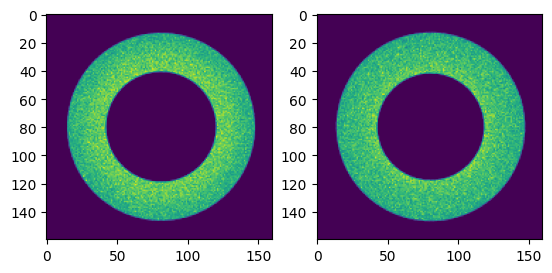

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pair.intra.stamp)
ax2.imshow(pair.extra.stamp)

In [6]:
np.savez("test_wfsim_data.npz", intra=pair.intra.stamp, extra=pair.extra.stamp)

In [7]:
from jf_wep.wfEstimator import WfEstimator
from jf_wep.donutStamp import DonutStamp

import batoid
import galsim

In [8]:
band = "r"
telescope = batoid.Optic.fromYaml(f"LSST_{band}.yaml")
bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")
wavelength = bandpass.effective_wavelength * 1e-9

# TODO: add field dependence here
zkIntrinsic = (
    batoid.zernike(
        telescope,
        *np.deg2rad((0, 0)),
        wavelength,
        jmax=66,
        eps=telescope.pupilObscuration,
    )
    * wavelength
)[4:]

# I put the donuts above in ts_wep, exp, onAxis, and these were the results
tswep = np.array(
    [
        -38.32302473,
        -1.91494541,
        34.19495879,
        -16.13682251,
        12.47399783,
        16.07579996,
        18.21226455,
        52.7725593,
        -5.98158415,
        -0.36171178,
        -10.84956834,
        -0.38731739,
        -2.27468556,
        2.55540124,
        -3.53461262,
        -3.06522024,
        1.91230257,
        0.72853264,
        -13.39105704,
    ]
)

In [9]:
wfEst = WfEstimator(algoConfig=dict(addIntrinsic=False, saveHistory=True))

In [10]:
zk = wfEst.estimateWf(
    DonutStamp(pair.intra.stamp, (0, 0), "intra"),
    DonutStamp(pair.extra.stamp, (0, 0), "extra"),
)

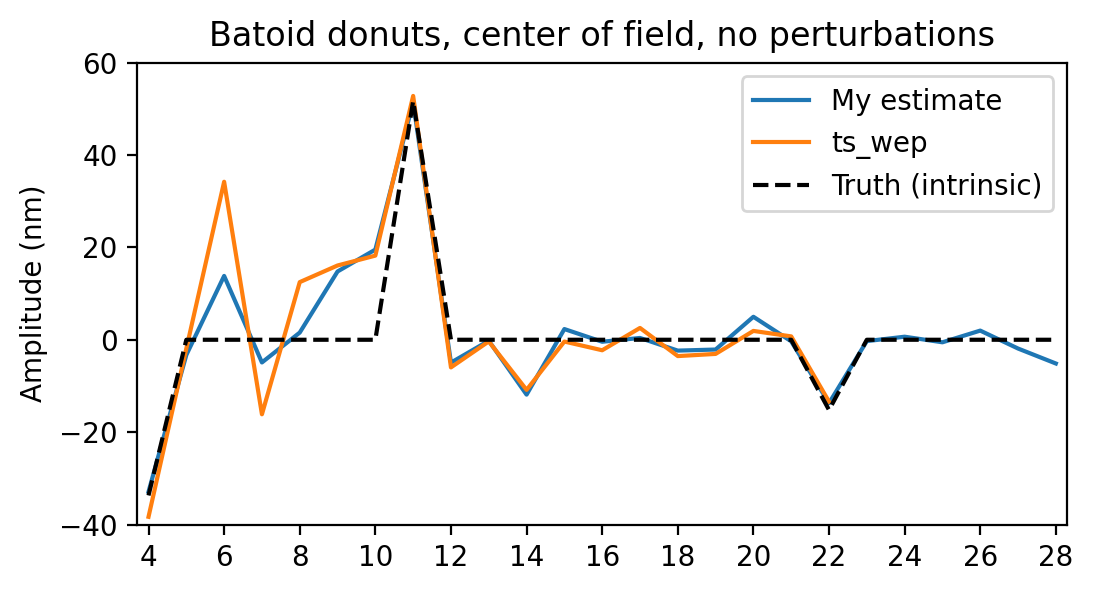

In [11]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
ax.plot(np.arange(4, len(zk) + 4), zk * 1e9, label="My estimate")
ax.plot(np.arange(4, len(tswep) + 4), tswep, label="ts_wep")
ax.plot(
    np.arange(4, len(zkIntrinsic[:25]) + 4),
    zkIntrinsic[:25] * 1e9,
    label="Truth (intrinsic)",
    c="k",
    ls="--",
)
ax.set(
    xlim=(3.7, 28.3),
    xticks=np.arange(4, 29, 2),
    ylabel="Amplitude (nm)",
    ylim=(-40, 60),
    title="Batoid donuts, center of field, no perturbations",
)
plt.legend()
plt.show()